<a href="https://colab.research.google.com/github/ManelSoengas/DL_Task2/blob/main/DL_task2_Roberta_13_8_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizamos/no utilizamos los datos aumentados mediante la técnica de swapping. Además la arquitectura contempla:


1.   Dropout y early_stopping
2.   Asignación de pesos en función del peso de la clase.
3.   La configuración y arquitectura se mantienen.



# **Cargar los recursos necesarios.**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.2 MB/s eta 0:00:00


#**Cargar los datos de entrada**

In [2]:
from sklearn.utils import shuffle
# Cargar datos preprocesados
#train_data = pd.read_csv('/content/EXIST2021_training.tsv', delimiter=',', encoding='latin1')
#test_data = pd.read_csv('/content/EXIST2021_test_labeled.tsv', delimiter=',', encoding='latin1')

test_data = pd.read_csv('/content/EXIST2021_test_labeled.tsv', sep='\t')
train_data = pd.read_csv('/content/swapp_EXIST2021_training.tsv', sep='\t') #swapping data_set training
# Mezclar los datos de entrenamiento
shuffled_train_data = shuffle(train_data, random_state=42)

# Mezclar los datos de prueba
shuffled_test_data = shuffle(test_data, random_state=42)

# **Visualizar estructura de los datos**

In [3]:
shuffled_train_data.head(10)

,test_case,id,source,language,text,task1,task2
2582,EXIST2021,2583,twitter,en,"@CritFacts @NyaVixa You're repeating yourself,...",sexist,ideological-inequality
8482,EXIST2021,452,twitter,en,I eat sooo much I really hope I don t ’ get fat,non-sexist,non-sexist
8061,EXIST2021,1659,twitter,en,MichaelRapaport @ Isn t ' this the same woman ...,non-sexist,non-sexist
10914,EXIST2021,5440,twitter,es,Paulxg_ @ Ponte a trabajar que tengo que ser m...,sexist,stereotyping-dominance
10162,EXIST2021,3614,twitter,es,"SofiaBVilla @ , rebelde , español soda , stere...",non-sexist,non-sexist
5688,EXIST2021,5689,twitter,es,Cuantas vidas ha salvado esta golfa al frente ...,sexist,misogyny-non-sexual-violence
8513,EXIST2021,1468,twitter,en,"* , because that was the BIGGEST - cock block ...",non-sexist,non-sexist
8645,EXIST2021,2739,twitter,en,The Socialist British Commonwealth of India is...,non-sexist,non-sexist
9265,EXIST2021,2722,twitter,en,In Spank “ ” prank we see how a woman is trick...,sexist,sexual-violence
3274,EXIST2021,3275,twitter,en,tw!! sh•••so much fucking bullshit today in my...,sexist,stereotyping-dominance


# **Distribución de la clase objetivo**

In [4]:

columna_clase_objetivo = "task2"

df = shuffled_train_data

# Contar la cantidad de categorías únicas en la columna de la clase objetivo
cantidad_categorias = df[columna_clase_objetivo].nunique()

# Contar la cantidad de muestras para cada categoría de la clase objetivo
muestras_por_categoria = df[columna_clase_objetivo].value_counts()

# Imprimir los resultados
print("Cantidad de categorías:", cantidad_categorias)
print("Muestras por categoría:")
print(muestras_por_categoria)
df.shape[0]

Cantidad de categorías: 6
Muestras por categoría:
non-sexist                      6180
ideological-inequality          1506
stereotyping-dominance          1366
misogyny-non-sexual-violence    1166
sexual-violence                  885
objectification                  874
Name: task2, dtype: int64


11977

#**Preprocesamiento** de los datos


---



1.   Anonimizar menciones, hastags y links.
2.   Convertir a minúsculas.
3.   Eliminar url que no utilizan http.
4.   Eliminar etiquetas hatml.
5.   Eliminar carácteres especiales.



In [5]:
import re

def anonimize_text(text):
    # Anonimizar nombres de usuario
    text = re.sub(r'@[\w_]+', '@user', text)

    # Anonimizar hashtags
    text = re.sub(r'#\w+', '#hashtag', text)

    # Anonimizar enlaces
    text = re.sub(r'https?://\S+', 'link', text)

    return text

shuffled_train_data['text_anonymized'] = shuffled_train_data['text'].apply(anonimize_text)
shuffled_test_data['text_anonymized'] = shuffled_test_data['text'].apply(anonimize_text)

In [6]:
# Convertir a minúsculas

shuffled_train_data.text_anonymized = shuffled_train_data.text_anonymized.str.lower()
shuffled_train_data.head(10)
shuffled_test_data.text_anonymized = shuffled_test_data.text_anonymized.str.lower()
shuffled_test_data.head(10)

,test_case,id,source,language,text,task1,task2,text_anonymized
1374,EXIST2021,8352,twitter,en,"if i ever catch anyone beating a women, i swea...",non-sexist,non-sexist,"if i ever catch anyone beating a women, i swea..."
2293,EXIST2021,9271,twitter,es,"""No sé si habrá un #MeToo del cine español. Cu...",non-sexist,non-sexist,"""no sé si habrá un #hashtag del cine español. ..."
3379,EXIST2021,10357,twitter,es,En el dia de hoy se sostuvo reunión con Claudi...,non-sexist,non-sexist,en el dia de hoy se sostuvo reunión con claudi...
1090,EXIST2021,8068,twitter,en,Man I love a good podcast. I highly recommend ...,non-sexist,non-sexist,man i love a good podcast. i highly recommend ...
1803,EXIST2021,8781,twitter,en,#BidenErasedWomen#BidenAintSmart#RealWomenMatt...,sexist,ideological-inequality,#hashtag#hashtag#hashtag not transgender!.#has...
2694,EXIST2021,9672,twitter,es,"tw/ transfobia ""no es opresión"" -hombres desle...",sexist,ideological-inequality,"tw/ transfobia ""no es opresión"" -hombres desle..."
461,EXIST2021,7439,twitter,en,@not_corona_ maybe its repressed antiblackness .,non-sexist,non-sexist,@user maybe its repressed antiblackness .
3346,EXIST2021,10324,twitter,es,@dara_ordonez ya nada es igual que cuando las ...,sexist,misogyny-non-sexual-violence,@user ya nada es igual que cuando las putas y ...
2297,EXIST2021,9275,twitter,es,"@modadulce Estoy de acuerdo, me parece que ten...",non-sexist,non-sexist,"@user estoy de acuerdo, me parece que tenemos ..."
2873,EXIST2021,9851,twitter,es,#BCSinAdicciones| FAIMUDEl día de hoy realizam...,non-sexist,non-sexist,#hashtag| faimudel día de hoy realizamos una m...


In [7]:
# Eliminar url/website que no usan http, solo utilizan .com websites
# Palabras separadas por a . no son eliminadas

shuffled_train_data.text_anonymized = shuffled_train_data.text_anonymized.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
shuffled_train_data.head(10)
shuffled_test_data.text_anonymized = shuffled_test_data.text_anonymized.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
shuffled_test_data.head(10)

,test_case,id,source,language,text,task1,task2,text_anonymized
1374,EXIST2021,8352,twitter,en,"if i ever catch anyone beating a women, i swea...",non-sexist,non-sexist,"if i ever catch anyone beating a women, i swea..."
2293,EXIST2021,9271,twitter,es,"""No sé si habrá un #MeToo del cine español. Cu...",non-sexist,non-sexist,"""no sé si habrá un #hashtag del cine español. ..."
3379,EXIST2021,10357,twitter,es,En el dia de hoy se sostuvo reunión con Claudi...,non-sexist,non-sexist,en el dia de hoy se sostuvo reunión con claudi...
1090,EXIST2021,8068,twitter,en,Man I love a good podcast. I highly recommend ...,non-sexist,non-sexist,man i love a good podcast. i highly recommend ...
1803,EXIST2021,8781,twitter,en,#BidenErasedWomen#BidenAintSmart#RealWomenMatt...,sexist,ideological-inequality,#hashtag#hashtag#hashtag not transgender!.#has...
2694,EXIST2021,9672,twitter,es,"tw/ transfobia ""no es opresión"" -hombres desle...",sexist,ideological-inequality,"tw/ transfobia ""no es opresión"" -hombres desle..."
461,EXIST2021,7439,twitter,en,@not_corona_ maybe its repressed antiblackness .,non-sexist,non-sexist,@user maybe its repressed antiblackness .
3346,EXIST2021,10324,twitter,es,@dara_ordonez ya nada es igual que cuando las ...,sexist,misogyny-non-sexual-violence,@user ya nada es igual que cuando las putas y ...
2297,EXIST2021,9275,twitter,es,"@modadulce Estoy de acuerdo, me parece que ten...",non-sexist,non-sexist,"@user estoy de acuerdo, me parece que tenemos ..."
2873,EXIST2021,9851,twitter,es,#BCSinAdicciones| FAIMUDEl día de hoy realizam...,non-sexist,non-sexist,#hashtag| faimudel día de hoy realizamos una m...


In [8]:
# Eliminar &text; etiquetas html

shuffled_train_data.text_anonymized = shuffled_train_data.text_anonymized.apply(lambda x: re.sub(r'&[a-zñ]+;', '', x))
shuffled_train_data.head(10)
shuffled_test_data.text_anonymized = shuffled_test_data.text_anonymized.apply(lambda x: re.sub(r'&[a-zñ]+;', '', x))
shuffled_test_data.head(10)

,test_case,id,source,language,text,task1,task2,text_anonymized
1374,EXIST2021,8352,twitter,en,"if i ever catch anyone beating a women, i swea...",non-sexist,non-sexist,"if i ever catch anyone beating a women, i swea..."
2293,EXIST2021,9271,twitter,es,"""No sé si habrá un #MeToo del cine español. Cu...",non-sexist,non-sexist,"""no sé si habrá un #hashtag del cine español. ..."
3379,EXIST2021,10357,twitter,es,En el dia de hoy se sostuvo reunión con Claudi...,non-sexist,non-sexist,en el dia de hoy se sostuvo reunión con claudi...
1090,EXIST2021,8068,twitter,en,Man I love a good podcast. I highly recommend ...,non-sexist,non-sexist,man i love a good podcast. i highly recommend ...
1803,EXIST2021,8781,twitter,en,#BidenErasedWomen#BidenAintSmart#RealWomenMatt...,sexist,ideological-inequality,#hashtag#hashtag#hashtag not transgender!.#has...
2694,EXIST2021,9672,twitter,es,"tw/ transfobia ""no es opresión"" -hombres desle...",sexist,ideological-inequality,"tw/ transfobia ""no es opresión"" -hombres desle..."
461,EXIST2021,7439,twitter,en,@not_corona_ maybe its repressed antiblackness .,non-sexist,non-sexist,@user maybe its repressed antiblackness .
3346,EXIST2021,10324,twitter,es,@dara_ordonez ya nada es igual que cuando las ...,sexist,misogyny-non-sexual-violence,@user ya nada es igual que cuando las putas y ...
2297,EXIST2021,9275,twitter,es,"@modadulce Estoy de acuerdo, me parece que ten...",non-sexist,non-sexist,"@user estoy de acuerdo, me parece que tenemos ..."
2873,EXIST2021,9851,twitter,es,#BCSinAdicciones| FAIMUDEl día de hoy realizam...,non-sexist,non-sexist,#hashtag| faimudel día de hoy realizamos una m...


In [9]:
# Eliminar caráctres especiales, #:)(/\='] usados en emojis y hashtags

shuffled_train_data.text_anonymized = shuffled_train_data.text_anonymized.str.replace("[^a-zA-ZñÑ#]", " ")
shuffled_train_data.head(10)
shuffled_test_data.text_anonymized = shuffled_test_data.text_anonymized.str.replace("[^a-zA-ZñÑ#]", " ")
shuffled_test_data.head(10)

<ipython-input-9-2f10188dda66>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  shuffled_train_data.text_anonymized = shuffled_train_data.text_anonymized.str.replace("[^a-zA-ZñÑ#]", " ")
<ipython-input-9-2f10188dda66>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  shuffled_test_data.text_anonymized = shuffled_test_data.text_anonymized.str.replace("[^a-zA-ZñÑ#]", " ")


,test_case,id,source,language,text,task1,task2,text_anonymized
1374,EXIST2021,8352,twitter,en,"if i ever catch anyone beating a women, i swea...",non-sexist,non-sexist,if i ever catch anyone beating a women i swea...
2293,EXIST2021,9271,twitter,es,"""No sé si habrá un #MeToo del cine español. Cu...",non-sexist,non-sexist,no s si habr un #hashtag del cine español ...
3379,EXIST2021,10357,twitter,es,En el dia de hoy se sostuvo reunión con Claudi...,non-sexist,non-sexist,en el dia de hoy se sostuvo reuni n con claudi...
1090,EXIST2021,8068,twitter,en,Man I love a good podcast. I highly recommend ...,non-sexist,non-sexist,man i love a good podcast i highly recommend ...
1803,EXIST2021,8781,twitter,en,#BidenErasedWomen#BidenAintSmart#RealWomenMatt...,sexist,ideological-inequality,#hashtag#hashtag#hashtag not transgender #has...
2694,EXIST2021,9672,twitter,es,"tw/ transfobia ""no es opresión"" -hombres desle...",sexist,ideological-inequality,tw transfobia no es opresi n hombres desle...
461,EXIST2021,7439,twitter,en,@not_corona_ maybe its repressed antiblackness .,non-sexist,non-sexist,user maybe its repressed antiblackness
3346,EXIST2021,10324,twitter,es,@dara_ordonez ya nada es igual que cuando las ...,sexist,misogyny-non-sexual-violence,user ya nada es igual que cuando las putas y ...
2297,EXIST2021,9275,twitter,es,"@modadulce Estoy de acuerdo, me parece que ten...",non-sexist,non-sexist,user estoy de acuerdo me parece que tenemos ...
2873,EXIST2021,9851,twitter,es,#BCSinAdicciones| FAIMUDEl día de hoy realizam...,non-sexist,non-sexist,#hashtag faimudel d a de hoy realizamos una m...


In [10]:
# Eliminar la columna 'text'
shuffled_train_data.drop('text', axis=1, inplace=True)
shuffled_test_data.drop('text', axis=1, inplace=True)
# Renombrar la columna 'text_anonimized' como 'text'
shuffled_train_data.rename(columns={'text_anonymized': 'text'}, inplace=True)
shuffled_train_data.head(10)
shuffled_test_data.rename(columns={'text_anonymized': 'text'}, inplace=True)
shuffled_test_data.head(10)

,test_case,id,source,language,task1,task2,text
1374,EXIST2021,8352,twitter,en,non-sexist,non-sexist,if i ever catch anyone beating a women i swea...
2293,EXIST2021,9271,twitter,es,non-sexist,non-sexist,no s si habr un #hashtag del cine español ...
3379,EXIST2021,10357,twitter,es,non-sexist,non-sexist,en el dia de hoy se sostuvo reuni n con claudi...
1090,EXIST2021,8068,twitter,en,non-sexist,non-sexist,man i love a good podcast i highly recommend ...
1803,EXIST2021,8781,twitter,en,sexist,ideological-inequality,#hashtag#hashtag#hashtag not transgender #has...
2694,EXIST2021,9672,twitter,es,sexist,ideological-inequality,tw transfobia no es opresi n hombres desle...
461,EXIST2021,7439,twitter,en,non-sexist,non-sexist,user maybe its repressed antiblackness
3346,EXIST2021,10324,twitter,es,sexist,misogyny-non-sexual-violence,user ya nada es igual que cuando las putas y ...
2297,EXIST2021,9275,twitter,es,non-sexist,non-sexist,user estoy de acuerdo me parece que tenemos ...
2873,EXIST2021,9851,twitter,es,non-sexist,non-sexist,#hashtag faimudel d a de hoy realizamos una m...


# **Carga de los recursos RoBERTa**

In [12]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            truncation_strategy='longest_first',
            return_attention_mask=True

        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [13]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")


# **Configuración**

In [11]:
MAX_LEN=255


In [14]:
X = shuffled_train_data['text'].values
y = shuffled_train_data['task2'].values
Z = shuffled_test_data['text'].values
z = shuffled_test_data['task2'].values

In [15]:
# Dividir los datos en entrenamiento y prueba
train_text, val_text, train_task2, val_task2 = train_test_split(X, y, test_size=0.2, random_state=42)

# **Codificación**

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

# Crear un objeto LabelEncoder para convertir las etiquetas de clase en valores numéricos
label_encoder = LabelEncoder()

# Ajustar el encoder con los datos de train_task2
label_encoder.fit(train_task2)

# Aplicar la transformación a los conjuntos de datos
train_task2_encoded = label_encoder.transform(train_task2)
val_task2_encoded = label_encoder.transform(val_task2)
z_encoded = label_encoder.transform(z)

# Ahora puedes usar train_task2_encoded, val_task2_encoded y z_encoded en tu modelo de clasificación

# Si deseas codificar las etiquetas de clase como one-hot encoded, utiliza OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# Ajustar el encoder one-hot con las etiquetas codificadas numéricamente
onehot_encoder.fit(train_task2_encoded.reshape(-1, 1))

# Aplicar la transformación one-hot a los conjuntos de datos
train_task2_onehot = onehot_encoder.transform(train_task2_encoded.reshape(-1, 1))
val_task2_onehot = onehot_encoder.transform(val_task2_encoded.reshape(-1, 1))
z_onehot = onehot_encoder.transform(z_encoded.reshape(-1, 1))

# Ahora train_task2_onehot, val_task2_onehot y z_onehot contienen las etiquetas de clase codificadas como one-hot

Estoy utilizando **LabelBinarizer** de Scikit-Learn para convertir las etiquetas de clase en codificación one-hot. La principal diferencia aquí es que uso fit una vez para ajustar el codificador con las etiquetas de clase, y luego uso transform para convertir las etiquetas de cada conjunto de datos (entrenamiento, validación, prueba) en codificación one-hot. Esto asegura que las mismas transformaciones se apliquen a todas las etiquetas, lo que es importante para mantener la consistencia.



In [16]:
from sklearn.preprocessing import LabelBinarizer

etiquetas_clase = ["non-sexist", "ideological-inequality", "stereotyping-dominance", "misogyny-non-sexual-violence", "sexual-violence", "objectification"]

# Crear un objeto LabelBinarizer para convertir las etiquetas de clase en one-hot encoding
label_binarizer = LabelBinarizer()

# Ajustar el LabelBinarizer con las etiquetas de clase
label_binarizer.fit(etiquetas_clase)

# Transformar las etiquetas de clase en one-hot encoding
train_task2_onehot = label_binarizer.transform(train_task2)
val_task2_onehot = label_binarizer.transform(val_task2)
z_onehot = label_binarizer.transform(z)

In [17]:
import numpy as np
train_input_ids, train_attention_masks = tokenize_roberta(train_text, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(val_text, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(Z, MAX_LEN)

In [18]:
print(train_input_ids.shape)
print(val_input_ids.shape)
print(test_input_ids.shape)

(9581, 255)
(2396, 255)
(4368, 255)


# **Cáculo y asignación de los pesos**

In [19]:
import numpy as np

# Frecuencias de las categorías
muestras_por_categoria = {
    "non-sexist": 6100,
    "ideological-inequality": 1506,
    "stereotyping-dominance": 1366,
    "misogyny-non-sexual-violence": 1166,
    "sexual-violence": 885,
    "objectification": 874
}

total_muestras = sum(muestras_por_categoria.values())

# Calcular las frecuencias relativas
frecuencias_relativas = {cat: count / total_muestras for cat, count in muestras_por_categoria.items()}

# Calcular los pesos inversamente proporcionales a las frecuencias
pesos = {cat: 1 / freq for cat, freq in frecuencias_relativas.items()}

# Normalizar los pesos
suma_pesos = sum(pesos.values())
pesos_normalizados = {cat: weight / suma_pesos for cat, weight in pesos.items()}

print(pesos_normalizados)


{'non-sexist': 0.0349409927849068, 'ideological-inequality': 0.1415272616121723, 'stereotyping-dominance': 0.15603225182132613, 'misogyny-non-sexual-violence': 0.18279593137901498, 'sexual-violence': 0.24083622145528977, 'objectification': 0.24386734094729}


In [20]:
import tensorflow as tf

# Crear el tensor de pesos para la función de pérdida
pesos_array = np.array(list(pesos_normalizados.values()))
pesos_tensor = tf.constant(pesos_array, dtype=tf.float32)

In [21]:
import tensorflow as tf

def create_multiclass_model(bert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    #loss = tf.keras.losses.SparseCategoricalCrossentropy()
    #accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    #loss = tf.keras.losses.CategoricalCrossentropy()
    loss = weighted_categorical_crossentropy  # Utilizamos la función con pesos

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    output = bert_model([input_ids, attention_masks])
    output = output[1]

    # Agregar Dropout
    output = tf.keras.layers.Dropout(0.5)(output)

    # Cambiar la salida para clasificación multiclase (6 clases)
    output = tf.keras.layers.Dense(6, activation='softmax')(output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compilar el modelo
    # Cambiar la métrica de BinaryAccuracy a CategoricalAccuracy
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Compilar el modelo
    model.compile(opt, loss=loss, metrics=[accuracy])

    # Agregar Early Stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')

    return model, early_stopping

    # Función de pérdida ponderada
#def weighted_categorical_crossentropy(y_true, y_pred):
    # Aplicar los pesos solo a las muestras positivas (las que tienen etiqueta 1)
    #weights = tf.reduce_sum(pesos_tensor * y_true, axis=1)
    #unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    #weighted_loss = unweighted_loss * weights
    #return tf.reduce_mean(weighted_loss)

    # Función de pérdida ponderada
def weighted_categorical_crossentropy(y_true, y_pred):
    # Convertir y_true a float32
    y_true = tf.cast(y_true, dtype=tf.float32)
    # Aplicar los pesos solo a las muestras positivas (las que tienen etiqueta 1)
    weights = tf.reduce_sum(pesos_tensor * y_true, axis=1)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)



In [22]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [23]:
#model = create_model(roberta_model, MAX_LEN)
model, early_stopping = create_multiclass_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 255)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 255)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 255,                                           

In [24]:
#history_2 = model.fit([train_input_ids,train_attention_masks], train_task2_onehot, validation_data=([val_input_ids,val_attention_masks], val_task2_onehot), epochs=8, batch_size=16)
history_2 = model.fit(
    [train_input_ids, train_attention_masks], train_task2_onehot,
    validation_data=([val_input_ids, val_attention_masks], val_task2_onehot),
    epochs=8,
    batch_size=32,
    callbacks=[early_stopping]  # Aquí se añade la devolución anticipada como callback
)

Epoch 1/8
300/300 [==============================] - 602s 2s/step - loss: 0.2068 - categorical_accuracy: 0.5176 - val_loss: 0.1700 - val_categorical_accuracy: 0.5618
Epoch 2/8
300/300 [==============================] - 519s 2s/step - loss: 0.1489 - categorical_accuracy: 0.6093 - val_loss: 0.1426 - val_categorical_accuracy: 0.6219
Epoch 3/8
300/300 [==============================] - 519s 2s/step - loss: 0.1187 - categorical_accuracy: 0.6865 - val_loss: 0.1298 - val_categorical_accuracy: 0.6544
Epoch 4/8
300/300 [==============================] - 520s 2s/step - loss: 0.0932 - categorical_accuracy: 0.7468 - val_loss: 0.1226 - val_categorical_accuracy: 0.7099
Epoch 5/8
300/300 [==============================] - 519s 2s/step - loss: 0.0745 - categorical_accuracy: 0.7894 - val_loss: 0.1171 - val_categorical_accuracy: 0.7429
Epoch 6/8
300/300 [==============================] - 519s 2s/step - loss: 0.0591 - categorical_accuracy: 0.8232 - val_loss: 0.1145 - val_categorical_accuracy: 0.7696
Epoc

In [25]:
result_roberta = model.predict([test_input_ids,test_attention_masks])


137/137 [==============================] - 78s 539ms/step


In [27]:
import numpy as np
from sklearn.metrics import f1_score

# Convertir las predicciones en etiquetas binarias (1 para la clase predicha, 0 para el resto)
predictions_binary = (result_roberta > 0.5).astype(np.int)

# Calcular la métrica F1
f1 = f1_score(z_onehot, predictions_binary, average='micro')

# Imprimir la métrica F1
print("F1 Score:", f1)


F1 Score: 0.601526717557252


<ipython-input-27-32625b0fdd13>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions_binary = (result_roberta > 0.5).astype(np.int)


In [26]:
# Evaluar el modelo
evaluation = model.evaluate([test_input_ids, test_attention_masks], z_onehot)

# Imprimir los resultados de la evaluación
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

137/137 [==============================] - 75s 544ms/step - loss: 0.2640 - categorical_accuracy: 0.6033
Loss: 0.26396265625953674
Accuracy: 0.6032509207725525


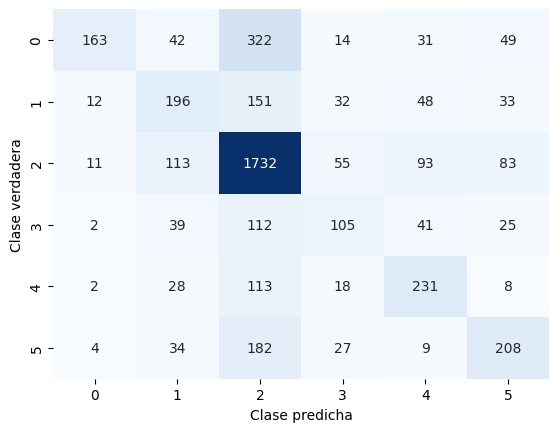

In [28]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que z_test.argmax(1) son las etiquetas reales y y_pred_roberta.argmax(1) son las etiquetas predichas
cm = confusion_matrix(z_onehot.argmax(1), y_pred_roberta.argmax(1))

# Crear un heatmap de la matriz de confusión
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Añadir etiquetas a los ejes
plt.xlabel("Clase predicha")
plt.ylabel("Clase verdadera")

# Mostrar el gráfico
plt.show()

# **Resultados**


---

Para 8 epochs, lr = 0.00001, batch_size = 32, datos no preprocesados, con datos  ampliados mediante técnica swapping y aplicación de pesos para compensar las clases minoritárias se obtiene:

##Training

```
Epoch 1/8
300/300 [==============================] - 581s 2s/step - loss: 0.2068 - categorical_accuracy: 0.5207 - val_loss: 0.1681 - val_categorical_accuracy: 0.5551
Epoch 2/8
300/300 [==============================] - 513s 2s/step - loss: 0.1486 - categorical_accuracy: 0.6157 - val_loss: 0.1490 - val_categorical_accuracy: 0.6031
Epoch 3/8
300/300 [==============================] - 513s 2s/step - loss: 0.1143 - categorical_accuracy: 0.6903 - val_loss: 0.1285 - val_categorical_accuracy: 0.6828
Epoch 4/8
300/300 [==============================] - 514s 2s/step - loss: 0.0867 - categorical_accuracy: 0.7607 - val_loss: 0.1268 - val_categorical_accuracy: 0.7091
Epoch 5/8
300/300 [==============================] - 513s 2s/step - loss: 0.0682 - categorical_accuracy: 0.8039 - val_loss: 0.1103 - val_categorical_accuracy: 0.7492
Epoch 6/8
300/300 [==============================] - 514s 2s/step - loss: 0.0513 - categorical_accuracy: 0.8408 - val_loss: 0.1112 - val_categorical_accuracy: 0.7705
Epoch 7/8
300/300 [==============================] - 514s 2s/step - loss: 0.0397 - categorical_accuracy: 0.8676 - val_loss: 0.1128 - val_categorical_accuracy: 0.7801
```
##Evaluación:


```
137/137 [==============================] - 74s 537ms/step - loss: 0.2442 - categorical_accuracy: 0.6108
Loss: 0.24421490728855133
Accuracy: 0.610805869102478
```




Para 8 epochs, lr = 0.00001 y batch_size = 32, sin preprocesar los datos, sin ampliar los datos de train mediante técnica swapping y con pesos se obtiene:

##Training:


```
Epoch 1/8
175/175 [==============================] - 379s 2s/step - loss: 0.2233 - categorical_accuracy: 0.5060 - val_loss: 0.1885 - val_categorical_accuracy: 0.4857
Epoch 2/8
175/175 [==============================] - 316s 2s/step - loss: 0.1791 - categorical_accuracy: 0.5472 - val_loss: 0.1556 - val_categorical_accuracy: 0.5738
Epoch 3/8
175/175 [==============================] - 314s 2s/step - loss: 0.1501 - categorical_accuracy: 0.6080 - val_loss: 0.1543 - val_categorical_accuracy: 0.5981
Epoch 4/8
175/175 [==============================] - 314s 2s/step - loss: 0.1271 - categorical_accuracy: 0.6633 - val_loss: 0.1481 - val_categorical_accuracy: 0.6225
Epoch 5/8
175/175 [==============================] - 315s 2s/step - loss: 0.1052 - categorical_accuracy: 0.7182 - val_loss: 0.1564 - val_categorical_accuracy: 0.6318
Epoch 6/8
175/175 [==============================] - 314s 2s/step - loss: 0.0865 - categorical_accuracy: 0.7620 - val_loss: 0.1878 - val_categorical_accuracy: 0.6504
```
##Evaluación:


```
137/137 [==============================] - 73s 535ms/step - loss: 0.2179 - categorical_accuracy: 0.6065
Loss: 0.2179282009601593
Accuracy: 0.6064560413360596
```





Para 8 epochs, lr = 0.00001 y batch_size = 16, sin preprocesar los datos, sin ampliar los datos de train mediante técnica swapping y con pesos se obtiene:

#Training:

```
Epoch 1/8
349/349 [==============================] - 394s 983ms/step - loss: 0.2145 - categorical_accuracy: 0.4996 - val_loss: 0.1677 - val_categorical_accuracy: 0.5623
Epoch 2/8
349/349 [==============================] - 312s 895ms/step - loss: 0.1673 - categorical_accuracy: 0.5639 - val_loss: 0.1479 - val_categorical_accuracy: 0.6003
Epoch 3/8
349/349 [==============================] - 328s 940ms/step - loss: 0.1353 - categorical_accuracy: 0.6418 - val_loss: 0.1509 - val_categorical_accuracy: 0.6125
Epoch 4/8
349/349 [==============================] - 328s 939ms/step - loss: 0.1101 - categorical_accuracy: 0.7056 - val_loss: 0.1545 - val_categorical_accuracy: 0.6383
```
#Evaluación


```
137/137 [==============================] - 75s 547ms/step - loss: 0.1825 - categorical_accuracy: 0.6147
Loss: 0.18250900506973267
Accuracy: 0.6146978139877319
```




Para 8 epochs, lr = 0.00001 y batch_size = 32, con preprocesamiento mínimo de los datos, sin ampliar los datos de train mediante técnica swapping y con pesos se obtiene:

#Training:


```
Epoch 1/8
175/175 [==============================] - 362s 2s/step - loss: 0.2292 - categorical_accuracy: 0.4809 - val_loss: 0.2015 - val_categorical_accuracy: 0.4778
Epoch 2/8
175/175 [==============================] - 320s 2s/step - loss: 0.1838 - categorical_accuracy: 0.5399 - val_loss: 0.1584 - val_categorical_accuracy: 0.5688
Epoch 3/8
175/175 [==============================] - 301s 2s/step - loss: 0.1516 - categorical_accuracy: 0.6044 - val_loss: 0.1586 - val_categorical_accuracy: 0.5709
Epoch 4/8
175/175 [==============================] - 303s 2s/step - loss: 0.1318 - categorical_accuracy: 0.6517 - val_loss: 0.1464 - val_categorical_accuracy: 0.6282
Epoch 5/8
175/175 [==============================] - 320s 2s/step - loss: 0.1139 - categorical_accuracy: 0.6974 - val_loss: 0.1486 - val_categorical_accuracy: 0.6282
Epoch 6/8
175/175 [==============================] - 319s 2s/step - loss: 0.0939 - categorical_accuracy: 0.7450 - val_loss: 0.1677 - val_categorical_accuracy: 0.6160
```

#Evaluación:


```
# 137/137 [==============================] - 72s 526ms/step - loss: 0.1979 - categorical_accuracy: 0.5852
Loss: 0.1978849172592163
Accuracy: 0.5851648449897766
```





Para 8 epochs, lr = 0.00001 y batch_size = 32, con preprocesamiento mínimo de los datos, ampliando los datos de train mediante técnica swapping y con pesos se obtiene:

#training:



```
Epoch 1/8
300/300 [==============================] - 602s 2s/step - loss: 0.2068 - categorical_accuracy: 0.5176 - val_loss: 0.1700 - val_categorical_accuracy: 0.5618
Epoch 2/8
300/300 [==============================] - 519s 2s/step - loss: 0.1489 - categorical_accuracy: 0.6093 - val_loss: 0.1426 - val_categorical_accuracy: 0.6219
Epoch 3/8
300/300 [==============================] - 519s 2s/step - loss: 0.1187 - categorical_accuracy: 0.6865 - val_loss: 0.1298 - val_categorical_accuracy: 0.6544
Epoch 4/8
300/300 [==============================] - 520s 2s/step - loss: 0.0932 - categorical_accuracy: 0.7468 - val_loss: 0.1226 - val_categorical_accuracy: 0.7099
Epoch 5/8
300/300 [==============================] - 519s 2s/step - loss: 0.0745 - categorical_accuracy: 0.7894 - val_loss: 0.1171 - val_categorical_accuracy: 0.7429
Epoch 6/8
300/300 [==============================] - 519s 2s/step - loss: 0.0591 - categorical_accuracy: 0.8232 - val_loss: 0.1145 - val_categorical_accuracy: 0.7696
Epoch 7/8
300/300 [==============================] - 520s 2s/step - loss: 0.0452 - categorical_accuracy: 0.8610 - val_loss: 0.1250 - val_categorical_accuracy: 0.7600
Epoch 8/8
300/300 [==============================] - 519s 2s/step - loss: 0.0381 - categorical_accuracy: 0.8770 - val_loss: 0.1170 - val_categorical_accuracy: 0.7742
```
#Evaluación:


```
137/137 [==============================] - 75s 544ms/step - loss: 0.2640 - categorical_accuracy: 0.6033
Loss: 0.26396265625953674
Accuracy: 0.6032509207725525
```


